In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np

In [2]:
epochs = 100
batch_size = 256
learning_rate = 0.1
patience = 30

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 625),
            nn.ReLU(),
            nn.Linear(625, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_correct /= size
    
    return test_loss, test_correct

In [6]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 88.01%, Train_loss: 0.444547, Test_accuracy: 93.66%, Test_loss: 0.212503
Epoch 2: Train_accuracy: 95.06%, Train_loss: 0.167781, Test_accuracy: 95.50%, Test_loss: 0.142053
Epoch 3: Train_accuracy: 96.68%, Train_loss: 0.112676, Test_accuracy: 96.64%, Test_loss: 0.106225
Epoch 4: Train_accuracy: 97.61%, Train_loss: 0.083466, Test_accuracy: 97.33%, Test_loss: 0.088435
Epoch 5: Train_accuracy: 98.14%, Train_loss: 0.064267, Test_accuracy: 97.56%, Test_loss: 0.079909
Epoch 6: Train_accuracy: 98.59%, Train_loss: 0.050515, Test_accuracy: 97.71%, Test_loss: 0.075392
Epoch 7: Train_accuracy: 98.90%, Train_loss: 0.040000, Test_accuracy: 97.79%, Test_loss: 0.071834
Epoch 8: Train_accuracy: 99.19%, Train_loss: 0.031839, Test_accuracy: 97.92%, Test_loss: 0.070337
Epoch 9: Train_accuracy: 99.43%, Train_loss: 0.025306, Test_accuracy: 98.01%, Test_loss: 0.069125
Epoch 10: Train_accuracy: 99.60%, Train_loss: 0.019971, Test_accuracy: 98.01%, Test_loss: 0.068192
Epoch 11: Train_acc

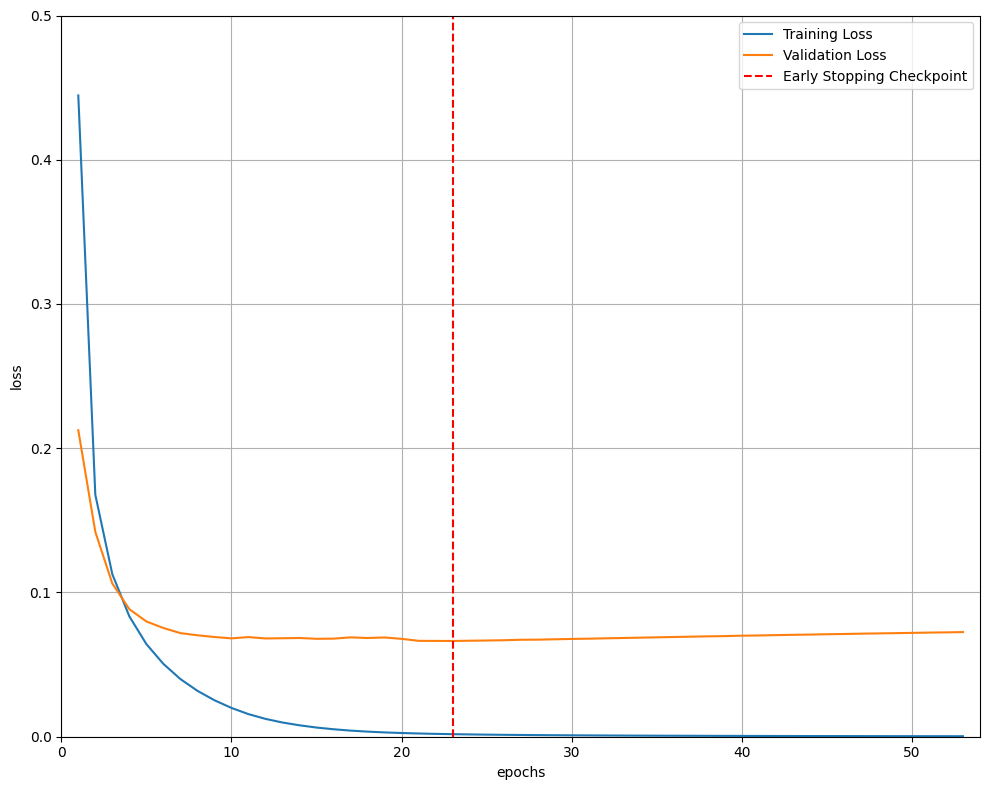

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(tr_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr_loss_reg, tr_correct_reg = [], []
te_loss_reg, te_correct_reg = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss_reg.append(train_loss), tr_correct_reg.append(train_correct)
    te_loss_reg.append(test_loss), te_correct_reg.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 87.71%, Train_loss: 0.453249, Test_accuracy: 93.50%, Test_loss: 0.214753
Epoch 2: Train_accuracy: 94.96%, Train_loss: 0.169586, Test_accuracy: 95.46%, Test_loss: 0.143815
Epoch 3: Train_accuracy: 96.67%, Train_loss: 0.114317, Test_accuracy: 96.50%, Test_loss: 0.110062
Epoch 4: Train_accuracy: 97.58%, Train_loss: 0.084850, Test_accuracy: 97.18%, Test_loss: 0.090765
Epoch 5: Train_accuracy: 98.14%, Train_loss: 0.065627, Test_accuracy: 97.49%, Test_loss: 0.079588
Epoch 6: Train_accuracy: 98.55%, Train_loss: 0.052107, Test_accuracy: 97.73%, Test_loss: 0.073141
Epoch 7: Train_accuracy: 98.89%, Train_loss: 0.041815, Test_accuracy: 97.79%, Test_loss: 0.069519
Epoch 8: Train_accuracy: 99.16%, Train_loss: 0.033832, Test_accuracy: 97.83%, Test_loss: 0.067685
Epoch 9: Train_accuracy: 99.38%, Train_loss: 0.027323, Test_accuracy: 97.89%, Test_loss: 0.066976
Epoch 10: Train_accuracy: 99.55%, Train_loss: 0.022121, Test_accuracy: 97.80%, Test_loss: 0.066744
Epoch 11: Train_acc

Epoch 84: Train_accuracy: 100.00%, Train_loss: 0.002177, Test_accuracy: 98.20%, Test_loss: 0.056116
Epoch 85: Train_accuracy: 100.00%, Train_loss: 0.002174, Test_accuracy: 98.20%, Test_loss: 0.056042
Epoch 86: Train_accuracy: 100.00%, Train_loss: 0.002174, Test_accuracy: 98.20%, Test_loss: 0.056063
Epoch 87: Train_accuracy: 100.00%, Train_loss: 0.002172, Test_accuracy: 98.21%, Test_loss: 0.055917
Epoch 88: Train_accuracy: 100.00%, Train_loss: 0.002170, Test_accuracy: 98.21%, Test_loss: 0.055948
Epoch 89: Train_accuracy: 100.00%, Train_loss: 0.002169, Test_accuracy: 98.21%, Test_loss: 0.055845
Epoch 90: Train_accuracy: 100.00%, Train_loss: 0.002167, Test_accuracy: 98.20%, Test_loss: 0.055787
Epoch 91: Train_accuracy: 100.00%, Train_loss: 0.002166, Test_accuracy: 98.21%, Test_loss: 0.055815
Epoch 92: Train_accuracy: 100.00%, Train_loss: 0.002164, Test_accuracy: 98.21%, Test_loss: 0.055737
Epoch 93: Train_accuracy: 100.00%, Train_loss: 0.002162, Test_accuracy: 98.21%, Test_loss: 0.055646


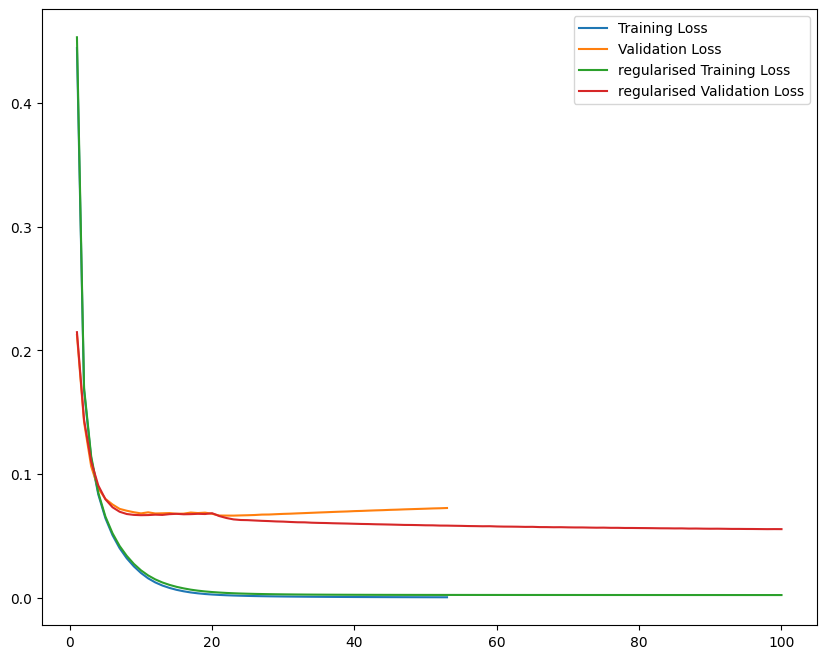

In [10]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.plot(range(1,len(tr_loss_reg)+1),tr_loss_reg, label='regularised Training Loss')
plt.plot(range(1,len(te_loss_reg)+1),te_loss_reg,label='regularised Validation Loss')
plt.legend()
plt.show()

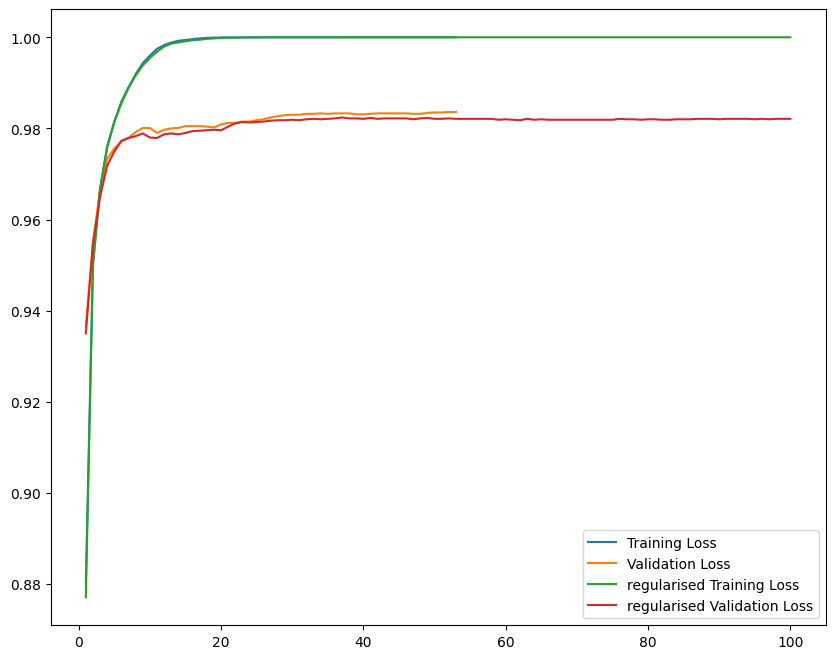

In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_correct)+1),tr_correct, label='Training Loss')
plt.plot(range(1,len(te_correct)+1),te_correct,label='Validation Loss')
plt.plot(range(1,len(tr_correct_reg)+1),tr_correct_reg, label='regularised Training Loss')
plt.plot(range(1,len(te_correct_reg)+1),te_correct_reg,label='regularised Validation Loss')
plt.legend()
plt.show()